In [231]:
import numpy as np
import sys
# option to import from github folder
sys.path.insert(0, '/media/carsen/DATA2/Github/suite2p')
import imp
from suite2p import run_s2p
from suite2p import utils
from skimage.external.tifffile import imread
from ScanImageTiffReader import ScanImageTiffReader

fs = ['/media/carsen/DATA2/grive/suite2p_test/example.tif']

fs = ['/media/carsen/DATA2/grive/suite2p_test/2016-07-27_8_M160704_FR096_2P_001_001.tif']

fs = ['/media/carsen/DATA1/TIFFS/SS05/20160517_SS05_02.tif']

fs = ['/media/carsen/DATA1/TIFFS/neurodroid/20180919_BG0039_sensor0_0000_corr.tif']

#for f in fs:
    
#    print(tif.shape())
    

In [232]:
data = imread(fs[0])
#im=tif.data()
print(data.shape)

(1024, 600, 600)


In [233]:
data=data[:400,:,:]

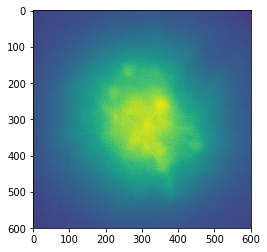

In [357]:
import matplotlib.pyplot as plt

plt.imshow(data[:50,:,:].mean(axis=0))

In [359]:
refImg=data[:50,:,:].mean(axis=0)

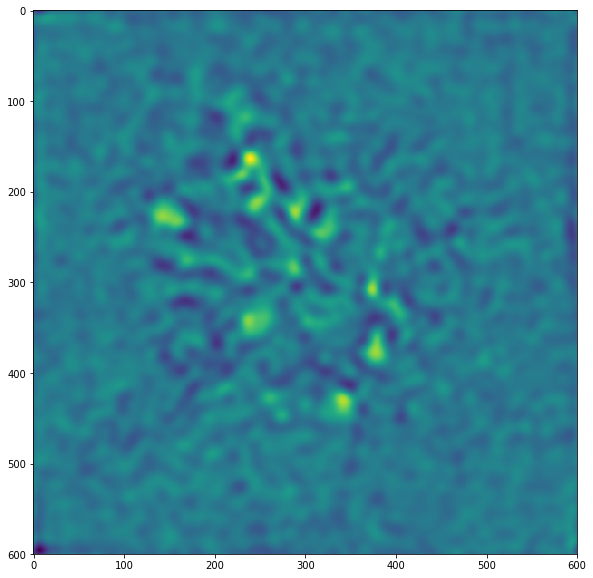

In [400]:
## from skimage import io
import glob, h5py, time, os, shutil
import numpy as np
from numpy import fft
from numpy import random as rnd
import multiprocessing
from multiprocessing import Pool
import math
from suite2p import nonrigid, utils
from scipy.signal import medfilt
from scipy.ndimage.filters import laplace

eps0=1e-5

ops={'smooth_sigma': 8}
maskSlope    = 3 * ops['smooth_sigma'] # slope of taper mask at the edges
Ly,Lx = refImg.shape
x = np.arange(0, Lx)
y = np.arange(0, Ly)
x = np.abs(x - x.mean())
y = np.abs(y - y.mean())
xx, yy = np.meshgrid(x, y)
mY = y.max() - 2*maskSlope
mX = x.max() - 2*maskSlope
maskY = 1./(1.+np.exp((yy-mY)/maskSlope))
maskX = 1./(1.+np.exp((xx-mX)/maskSlope))
maskMul = maskY * maskX
maskOffset = refImg.mean() * (1. - maskMul);

# reference image in fourier domain
cfRefImg   = np.conj(fft.fft2(refImg));
absRef     = np.absolute(cfRefImg);
cfRefImg   = cfRefImg / (eps0 + absRef)

# gaussian
hgx = np.exp(-np.square(xx/ops['smooth_sigma']) / 2)
hgy = np.exp(-np.square(yy/ops['smooth_sigma']) / 2)
hgg = hgy * hgx
hgg /= hgg.sum()

laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

im = np.zeros((Ly,Lx))
im[np.ix_(int(np.ceil(Ly/2))+np.arange(-1,2,dtype=int),
          int(np.ceil(Lx/2))+np.arange(-1,2,dtype=int))] = laplacian
imout = im
#im[int(np.ceil(Ly/2)),int(np.ceil(Lx/2))] = 1
#imout = laplace(im, mode='reflect', cval=0)

#hgg = hgg * imout

#hgx = np.exp(-np.square(xx/(25*ops['smooth_sigma'])) / 2)
#hgy = np.exp(-np.square(yy/(25*ops['smooth_sigma'])) / 2)
#hgg2 = hgy * hgx
#hgg2 /= hgg2.sum()
#hgg  -= hgg2
hgg = 1 * hgg * (1 - (xx**2 + yy**2) / (2 * 2 * ops['smooth_sigma']**2))
fhg = np.real(fft.fft2(fft.ifftshift(hgg))); # smoothing filter in Fourier domain
#fhg *= (fft.fft2(fft.ifftshift(imout)))

cfRefImg *= fhg

plt.figure(figsize=(10,10))
plt.imshow(np.real(fft.ifft2(cfRefImg)))
#plt.imshow(fhg)

In [401]:
nimg, Ly, Lx = data.shape
cfRefImg = np.reshape(cfRefImg, (1, Ly, Lx))
#data = data.astype('float32') * maskMul + maskOffset
X = fft.fft2(data)
#if do_phasecorr:
X = X / (eps0 + np.absolute(X))
X = X * cfRefImg
cc = np.real(fft.ifft2(X))
cc = fft.fftshift(cc, axes=(1,2))

lcorr=80
lpad=3
Lyhalf = int(np.floor(Ly/2))
Lxhalf = int(np.floor(Lx/2))
from suite2p.register import getXYup, shift_data
ops['subpixel']=10
ymax,xmax,cmax,snr = getXYup(cc,(lcorr, lpad,Lyhalf,Lxhalf),ops)

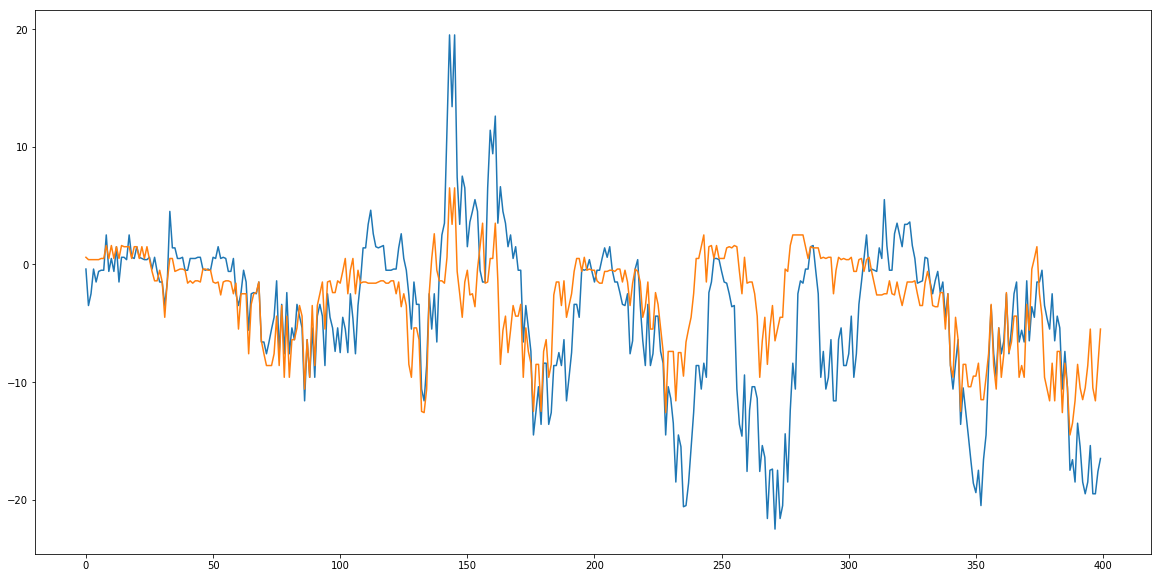

In [402]:
plt.figure(figsize=(20,10))
plt.plot(ymax[:])
plt.plot(xmax[:])
plt.show()

In [403]:
dout = shift_data((data,ymax,xmax))

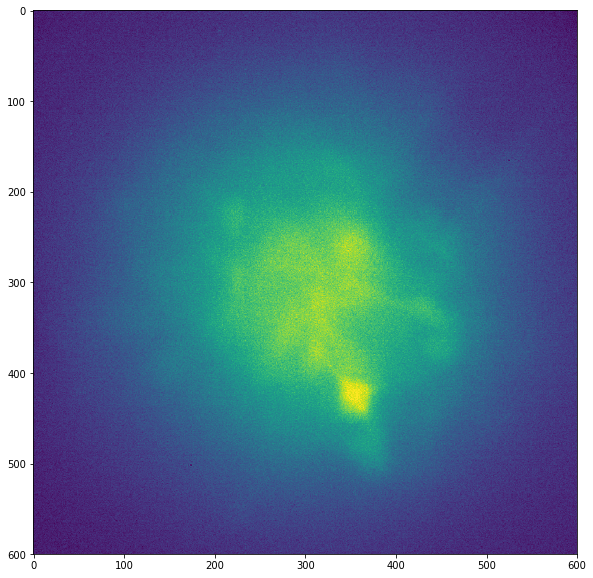

In [404]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10,10))

#line, = ax.plot([], [], lw=2)
im = ax.imshow(dout[0,:,:])

# initialization function: plot the background of each frame
def init():
    im.set_data(dout[0,:,:])
    return (im,)
# animation function. This is called sequentially
def animate(i):
    im.set_data(dout[i,:,:])
    return (im,)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=100, blit=True)
HTML(anim.to_html5_video())

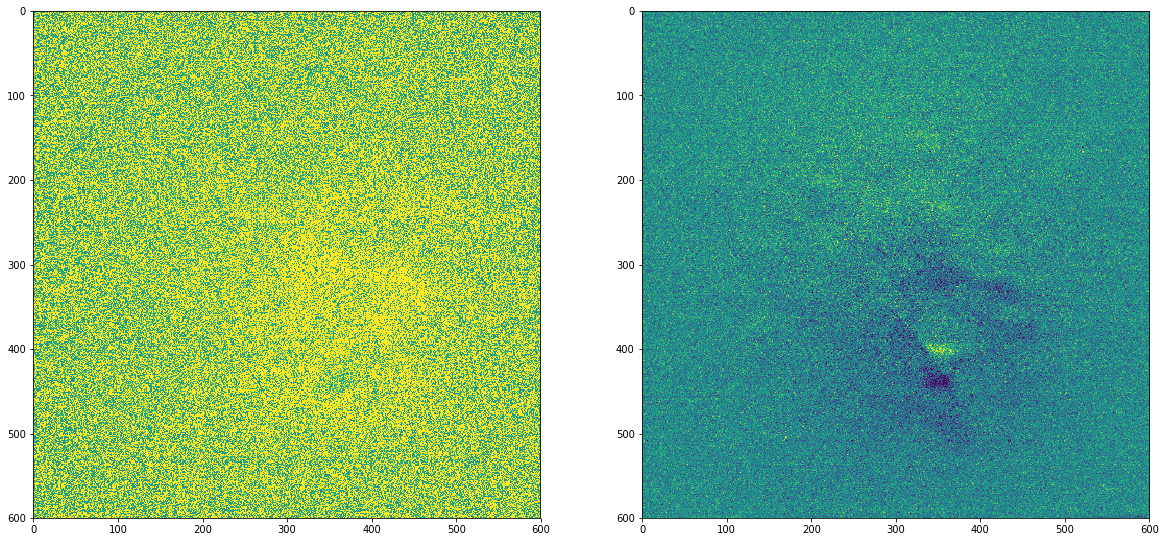

In [261]:
plt.figure(figsize=(20,10))
ix=186
vm=-40
vx=40
plt.subplot(1,2,1)
plt.imshow(data[ix,:,:]-data[ix+1,:,:],vmin=vm,vmax=vx)
plt.subplot(1,2,2)
plt.imshow(dout[ix,:,:]-dout[ix+1,:,:],vmin=vm,vmax=vx)

In [222]:
dout=data

In [24]:
from skimage.external.tifffile import TiffFile

#fs = ['/home/carsen/TIFFS/TSeries-20170508-D43-001_Cycle00001_Ch2_000001.ome.tif']
fs = ['/home/carsen/TIFFS/MP032/2017-08-01_6_M170714_MP032_2P_001_001.tif'];

import time

tic = time.time()
tif = TiffFile(fs[0])
print(time.time()-tic)

print(tif[0].asarray())

0.5982632637023926
[[ 75  66  60 ... 187 162  80]
 [ 69  52  66 ... 118 115 139]
 [ 69  77  71 ... 135  76  83]
 ...
 [ 66  64  84 ...  77  79  68]
 [ 66  57  70 ...  85  79  74]
 [ 87  75  68 ...  79  76  53]]


In [28]:
1800/12 * 5

750.0

In [59]:
F = np.load('/home/carsen/Downloads/suite2p/plane0/F.npy')
F.shape

(954, 2000)

In [67]:
import scipy.io

Fall = scipy.io.loadmat('/home/carsen/Downloads/suite2p/plane0/Fall.mat',squeeze_me=True)

In [69]:
Fall['F'].shape

(671, 2000)